In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
import urllib, json
from PIL import Image
import datetime
import openpyxl
import seaborn as sns

In [3]:
# Подключаем api_key из файла
f = open('API_KEY.txt', 'r')
api_key = f.read()
f.close()

In [4]:
# Составляем URL request
api_root = 'https://api.nasa.gov/'
api_product = 'neo/rest/v1/feed?'
start_date = '2021-01-01'
end_date = '2021-01-01'
url = f"{api_root}{api_product}start_date={start_date}&end_date={end_date}&api_key={api_key}"

In [5]:
'''
Функция навигации по данным из api response   
возвращает ссылку на данные в другом временном отрезке

    step = 'next' -- следующий день от заданного start_date в URL request
    step = 'prev' -- предыдущий день от заданного start_date в URL request
    step = 'self' -- текущий день, равный start_date в URL request
'''

def get_url(url, step):
    url_level = urllib.request.urlopen(url)
    data_level = json.loads(url_level.read())['links']
    if step == 'next':
        return data_level[step]
    elif step == 'prev':
        return data_level[step]
    elif step == 'self':
        return data_level[step]

In [6]:
'''
Вариант использования бибилотеки datetime для скольжения по датам (не используется в коде)
и вывод даты в строку

delta = datetime.timedelta(days=1)
day_current = datetime.date.fromisoformat(start_date) + delta
date_str = datetime.date.strftime(day_current, '%Y-%m-%d')
'''

"\nВариант использования бибилотеки datetime для скольжения по датам (не используется в коде)\nи вывод даты в строку\n\ndelta = datetime.timedelta(days=1)\nday_current = datetime.date.fromisoformat(start_date) + delta\ndate_str = datetime.date.strftime(day_current, '%Y-%m-%d')\n"

In [7]:
'''Навигация по ссылкам.

Работаем с данными за один день 2020-07-07.
Обрабатываем входящий json.
'''

url_level_0 = urllib.request.urlopen(url)
data_level_0 = pd.DataFrame.from_dict(json.loads(url_level_0.read()))
data_level_0

,links,element_count,near_earth_objects
next,http://api.nasa.gov/neo/rest/v1/feed?start_dat...,11,NaN
prev,http://api.nasa.gov/neo/rest/v1/feed?start_dat...,11,NaN
self,http://api.nasa.gov/neo/rest/v1/feed?start_dat...,11,NaN
2021-01-01,NaN,11,[{'links': {'self': 'http://api.nasa.gov/neo/r...


In [8]:
# Выбираем один элемент из списка за один день
data_day = data_level_0.near_earth_objects[3]
data_day_item = data_day[0]
data_day_item

{'links': {'self': 'http://api.nasa.gov/neo/rest/v1/neo/3364161?api_key=8Mbg6rxSagXNYxrUbC8ynidJUcLn9h4CC7ucuT21'},
 'id': '3364161',
 'neo_reference_id': '3364161',
 'name': '(2006 YV1)',
 'nasa_jpl_url': 'http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3364161',
 'absolute_magnitude_h': 21.64,
 'estimated_diameter': {'kilometers': {'estimated_diameter_min': 0.1248978541,
   'estimated_diameter_max': 0.2792800919},
  'meters': {'estimated_diameter_min': 124.8978540673,
   'estimated_diameter_max': 279.2800919383},
  'miles': {'estimated_diameter_min': 0.0776079045,
   'estimated_diameter_max': 0.17353655},
  'feet': {'estimated_diameter_min': 409.769875538,
   'estimated_diameter_max': 916.2732968347}},
 'is_potentially_hazardous_asteroid': False,
 'close_approach_data': [{'close_approach_date': '2021-01-01',
   'close_approach_date_full': '2021-Jan-01 23:03',
   'epoch_date_close_approach': 1609542180000,
   'relative_velocity': {'kilometers_per_second': '26.8953448395',
    'kilometers_per_ho

In [9]:
# Создаем словари с необходимями данными для DataFrame
dict_estimated_diameter = data_day_item['estimated_diameter']['kilometers']
dict_close_approach_data = data_day_item['close_approach_data'][0]
dict_relative_velocity = dict_close_approach_data['relative_velocity']
dict_miss_distance = dict_close_approach_data['miss_distance']

In [10]:
# Чистим словарь от вложенных словарей
keys = ['links','estimated_diameter','close_approach_data', 'relative_velocity', 'miss_distance']

for key in keys:
    data_day_item.pop(key, None)
data_day_item_short = data_day_item

data_day_item_short

{'id': '3364161',
 'neo_reference_id': '3364161',
 'name': '(2006 YV1)',
 'nasa_jpl_url': 'http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3364161',
 'absolute_magnitude_h': 21.64,
 'is_potentially_hazardous_asteroid': False,
 'is_sentry_object': False}

In [11]:
'''Создаем DataFrame для выбранных данных.

Объединяем DataFrame в один для дальнейшей работы.
'''

df1 = pd.DataFrame([data_day_item_short])
df2 = pd.DataFrame(dict_estimated_diameter, index=[0]).reset_index(drop=True)
df3 = pd.DataFrame(dict_close_approach_data, index=[0]).reset_index(drop=True)
df4 = pd.DataFrame(dict_relative_velocity, index=[0]).reset_index(drop=True)
df5 = pd.DataFrame(dict_miss_distance, index=[0]).reset_index(drop=True)
df_item = df1.join(df2).join(df3).join(df4).join(df5)

df_item

,id,neo_reference_id,name,nasa_jpl_url,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,estimated_diameter_min,estimated_diameter_max,close_approach_date,...,relative_velocity,miss_distance,orbiting_body,kilometers_per_second,kilometers_per_hour,miles_per_hour,astronomical,lunar,kilometers,miles
0,3364161,3364161,(2006 YV1),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3364161,21.64,False,False,0.124898,0.27928,2021-01-01,...,NaN,NaN,Earth,26.8953448395,96823.2414221104,60162.1968714219,0.44581924,173.42368436,66693608.7090188,41441486.78450744


In [12]:
# Чистим DataFrame от нерелевантных данных, переименовываем
df_item = df1.join(df2).join(df3).join(df4).join(df5).drop(['nasa_jpl_url',
                                                'neo_reference_id',
                                                'miss_distance',
                                                'miles_per_hour',
                                                'astronomical',
                                                'lunar',
                                                'miles'
                                                ], axis=1
).rename(columns={'kilometers': 'miss_distance_kilometers',
                'estimated_diameter_min': 'estimated_diameter_km_min',
                'estimated_diameter_max': 'estimated_diameter_km_max'})

# Создаем словарь из DataFrame
df_item.to_dict()

{'id': {0: '3364161'},
 'name': {0: '(2006 YV1)'},
 'absolute_magnitude_h': {0: 21.64},
 'is_potentially_hazardous_asteroid': {0: False},
 'is_sentry_object': {0: False},
 'estimated_diameter_km_min': {0: 0.1248978541},
 'estimated_diameter_km_max': {0: 0.2792800919},
 'close_approach_date': {0: '2021-01-01'},
 'close_approach_date_full': {0: '2021-Jan-01 23:03'},
 'epoch_date_close_approach': {0: 1609542180000},
 'relative_velocity': {0: nan},
 'orbiting_body': {0: 'Earth'},
 'kilometers_per_second': {0: '26.8953448395'},
 'kilometers_per_hour': {0: '96823.2414221104'},
 'miss_distance_kilometers': {0: '66693608.7090188'}}

**Создаем цикл для работы с API с получением данных за определенное количество дней**

In [13]:
'''Структуры для работы.

items_list - список из данных по каждому объекту за определенный период
missed_colums_keys = [] - список для обработки словаря по одному объекту (удаление столбцов)
'''
items_list = []
missed_colums_keys = [
    'links','estimated_diameter',
    'close_approach_data',
    'relative_velocity',
    'miss_distance'
    ]

In [14]:
'''Создание списка заголовков

для требуемого пустого DataFrame
из DataFrame за один день
'''
key_list = list(df_item.to_dict())
key_list.remove('epoch_date_close_approach')
key_list.remove('relative_velocity')
key_list

['id',
 'name',
 'absolute_magnitude_h',
 'is_potentially_hazardous_asteroid',
 'is_sentry_object',
 'estimated_diameter_km_min',
 'estimated_diameter_km_max',
 'close_approach_date',
 'close_approach_date_full',
 'orbiting_body',
 'kilometers_per_second',
 'kilometers_per_hour',
 'miss_distance_kilometers']

In [15]:
# Создаем пустой DataFrame
df0 = pd.DataFrame(columns=key_list)

df0

,id,name,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,estimated_diameter_km_min,estimated_diameter_km_max,close_approach_date,close_approach_date_full,orbiting_body,kilometers_per_second,kilometers_per_hour,miss_distance_kilometers


In [18]:
# n - количество запросов(дней)
n = 10

In [19]:
''' Создаем цикл для получения данных

через API за заданный период времени
на основе алгоритма получения данных
за один день
'''


for i in range(1, n):
    current = get_url(url, 'next')
    url = current
    
    # Навигация по ссылкам, работаем с данными за один день
    url_level_0 = urllib.request.urlopen(url)
    data_level_0 = pd.DataFrame.from_dict(json.loads(url_level_0.read()))
    
    # Cписок элементов за один день
    data_in_day = data_level_0.near_earth_objects[3]

    # Цикл по элементам списка за один день
    for data_day_item in data_in_day:
        dict_estimated_diameter = data_day_item['estimated_diameter']['kilometers']
        dict_close_approach_data = data_day_item['close_approach_data'][0]
        dict_relative_velocity = dict_close_approach_data['relative_velocity']
        dict_miss_distance = dict_close_approach_data['miss_distance']

        # Чистим словарь от вложенных словарей
        for key in missed_colums_keys:
            data_day_item.pop(key, None)

        data_day_item_short = data_day_item
        
        # Создаем Dataframe из вложенных словарей
        df1 = pd.DataFrame([data_day_item_short])
        df2 = pd.DataFrame(dict_estimated_diameter, index=[0]).reset_index(drop=True)
        df3 = pd.DataFrame(dict_close_approach_data, index=[0]).reset_index(drop=True)
        df4 = pd.DataFrame(dict_relative_velocity, index=[0]).reset_index(drop=True)
        df5 = pd.DataFrame(dict_miss_distance, index=[0]).reset_index(drop=True)
        
        # Чистим DataFrame от нерелевантных данных, переименовываем
        df_item = df1.join(df2).join(df3).join(df4).join(df5).drop(['nasa_jpl_url',
                                                        'neo_reference_id',
                                                        'miss_distance',
                                                        'miles_per_hour',
                                                        'astronomical',
                                                        'lunar',
                                                        'miles',
                                                        'epoch_date_close_approach',
                                                        'relative_velocity'
                                                        ], axis=1
        ).rename(columns={'kilometers': 'miss_distance_kilometers',
                        'estimated_diameter_min': 'estimated_diameter_km_min',
                        'estimated_diameter_max': 'estimated_diameter_km_max'})
        

        # Добавление в итоговый DataFrame данных построчно
        df0 = pd.concat([df0, df_item])

In [20]:
df0.dtypes

id                                    object
name                                  object
absolute_magnitude_h                 float64
is_potentially_hazardous_asteroid     object
is_sentry_object                      object
estimated_diameter_km_min            float64
estimated_diameter_km_max            float64
close_approach_date                   object
close_approach_date_full              object
orbiting_body                         object
kilometers_per_second                 object
kilometers_per_hour                   object
miss_distance_kilometers              object
dtype: object

In [21]:
# Меняем тип данных, округляем float
df0['id'] = df0['id'].astype(float).astype(int)
df0['is_potentially_hazardous_asteroid'] = (df0['is_potentially_hazardous_asteroid']*1).astype(int)
df0['is_sentry_object'] = (df0['is_sentry_object']*1).astype(int)
df0['absolute_magnitude_h'] = df0['absolute_magnitude_h'].astype('float64').round(2)
df0['kilometers_per_second'] = df0['kilometers_per_second'].astype('float64').round(3)
df0['estimated_diameter_km_min'] = df0['estimated_diameter_km_min'].astype('float32').round(3)
df0['estimated_diameter_km_max'] = df0['estimated_diameter_km_max'].astype('float32').round(3)
df0['close_approach_date'] = pd.to_datetime(df0['close_approach_date'])
df0['close_approach_date_full'] = pd.to_datetime(df0['close_approach_date_full'])
df0['kilometers_per_hour'] = df0['kilometers_per_hour'].astype(float).astype(int)
df0['miss_distance_kilometers'] = df0['miss_distance_kilometers'].astype(float).astype(int)
df0.dtypes

id                                            int32
name                                         object
absolute_magnitude_h                        float64
is_potentially_hazardous_asteroid             int32
is_sentry_object                              int32
estimated_diameter_km_min                   float32
estimated_diameter_km_max                   float32
close_approach_date                  datetime64[ns]
close_approach_date_full             datetime64[ns]
orbiting_body                                object
kilometers_per_second                       float64
kilometers_per_hour                           int32
miss_distance_kilometers                      int32
dtype: object

In [22]:
df0

,id,name,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,estimated_diameter_km_min,estimated_diameter_km_max,close_approach_date,close_approach_date_full,orbiting_body,kilometers_per_second,kilometers_per_hour,miss_distance_kilometers
0,3471590,(2009 TK12),20.60,1,0,0.202,0.451,2021-01-02,2021-01-02 21:38:00,Earth,13.155,47359,37817502
0,3477945,(2009 WN8),25.20,0,0,0.024,0.054,2021-01-02,2021-01-02 16:51:00,Earth,9.200,33119,35660265
0,3703247,(2014 YD42),22.20,0,0,0.097,0.216,2021-01-02,2021-01-02 23:27:00,Earth,22.553,81191,52916844
0,3756788,(2016 PN),20.30,0,0,0.232,0.518,2021-01-02,2021-01-02 20:26:00,Earth,18.046,64965,56392979
0,3766183,(2016 YS8),21.40,0,0,0.139,0.312,2021-01-02,2021-01-02 00:00:00,Earth,18.382,66174,71330162
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,54106587,(2021 BV2),22.70,0,0,0.077,0.171,2021-01-11,2021-01-11 11:24:00,Earth,15.471,55695,45638350
0,54166589,(2021 NM1),29.10,0,0,0.004,0.009,2021-01-11,2021-01-11 17:18:00,Earth,6.532,23515,60106156
0,54170847,(2021 NB8),28.15,0,0,0.006,0.014,2021-01-11,2021-01-11 09:32:00,Earth,6.664,23989,54225670
0,54190080,(2021 QO1),26.87,0,0,0.011,0.025,2021-01-11,2021-01-11 17:07:00,Earth,7.705,27736,58604103


In [29]:
df0 = pd.read_excel("NASA_Asteroids_2021.xlsx",header=0)
#df_sum = pd.concat([df_from_xlsx, df0])
#df_from_xlsx.to_excel("NASA_Asteroids_2021.xlsx",
#             sheet_name='Sheet_1')

In [ ]:
#df_temp = df_from_xlsx.drop(['Unnamed: 0'], axis=1)
#df_temp

In [ ]:
#aaa.to_csv('NASA_Asteroids_2021.csv')

Исследуем зависимость максимального диаметра астероида от его магнитуды с учетом потенциальной опасности астероиды

<Axes: xlabel='absolute_magnitude_h', ylabel='estimated_diameter_km_max'>

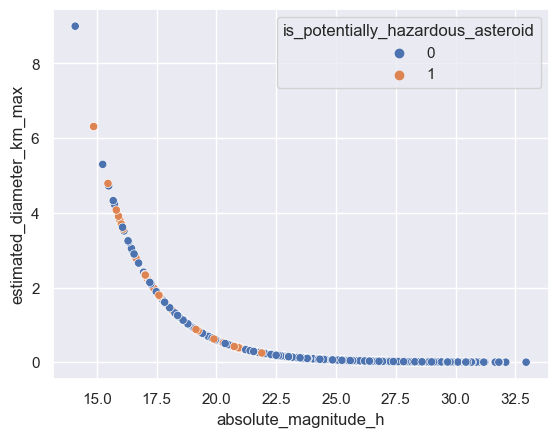

In [60]:
sns.scatterplot(data=df0, 
                x="absolute_magnitude_h",
                y="estimated_diameter_km_max",
                hue="is_potentially_hazardous_asteroid")

Исследуем зависимость минимального расстояния до планеты от его магнитуды с учетом потенциальной опасности астероиды

<Axes: xlabel='absolute_magnitude_h', ylabel='miss_distance_kilometers'>

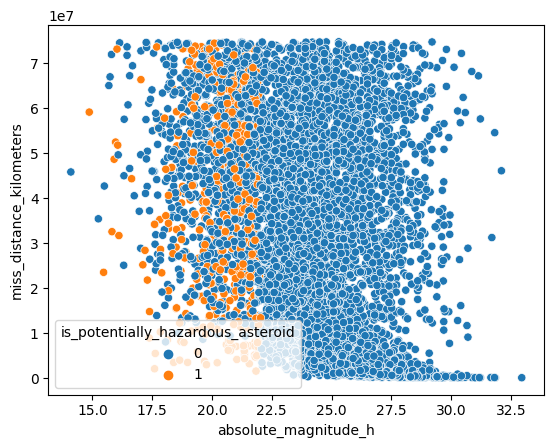

In [34]:
sns.scatterplot(data=df0, 
                x="absolute_magnitude_h",
                y="miss_distance_kilometers",
                hue="is_potentially_hazardous_asteroid")

Исследуем зависимость минимального расстояния до планеты от его скорости с учетом потенциальной опасности астероиды

<Axes: xlabel='kilometers_per_second', ylabel='miss_distance_kilometers'>

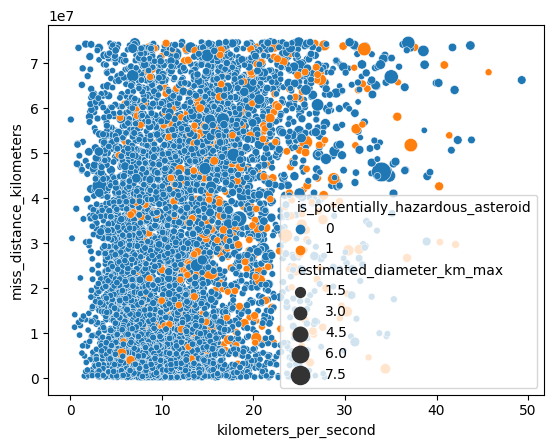

In [45]:
sns.scatterplot(data=df0, 
                x="kilometers_per_second",
                y="miss_distance_kilometers",
                hue="is_potentially_hazardous_asteroid",
                size="estimated_diameter_km_max",
                sizes=(20, 200))

Исследуем зависимость скорости астероида от магнитуды с учетом потенциальной опасности астероиды

<Axes: xlabel='kilometers_per_second', ylabel='absolute_magnitude_h'>

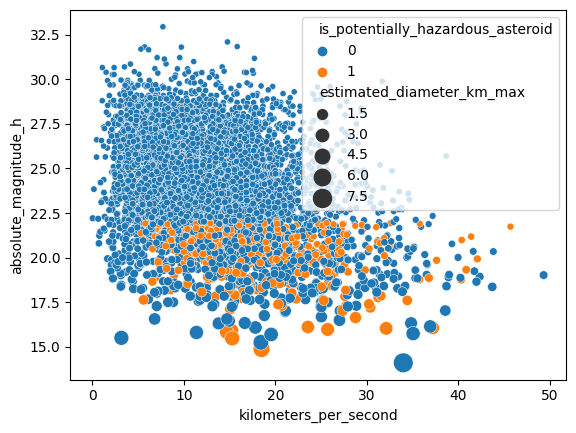

In [46]:
sns.scatterplot(data=df0, 
                x="kilometers_per_second",
                y="absolute_magnitude_h",
                hue="is_potentially_hazardous_asteroid",
                size="estimated_diameter_km_max",
                sizes=(20, 200)
                )

Исследуем зависимость количества астероидов за временной период с учетом потенциальной опасности астероиды

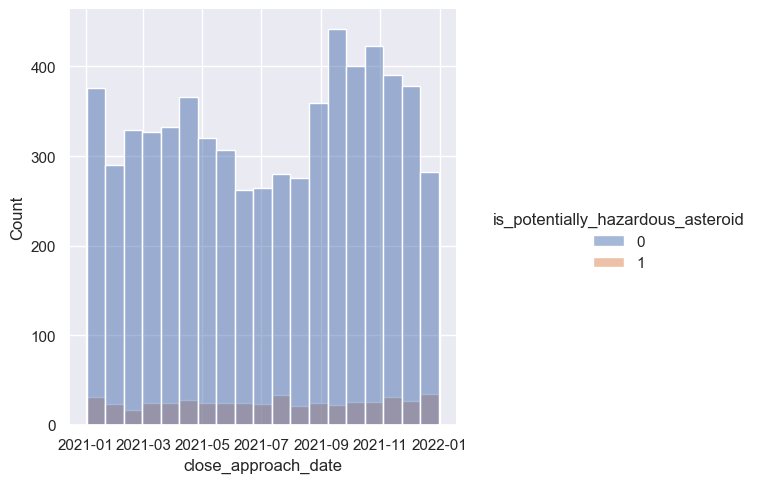

In [53]:
sns.set_theme(style="darkgrid")
#df = sns.load_dataset("df0")
sns.displot(data=df0, x="close_approach_date",
            hue="is_potentially_hazardous_asteroid")

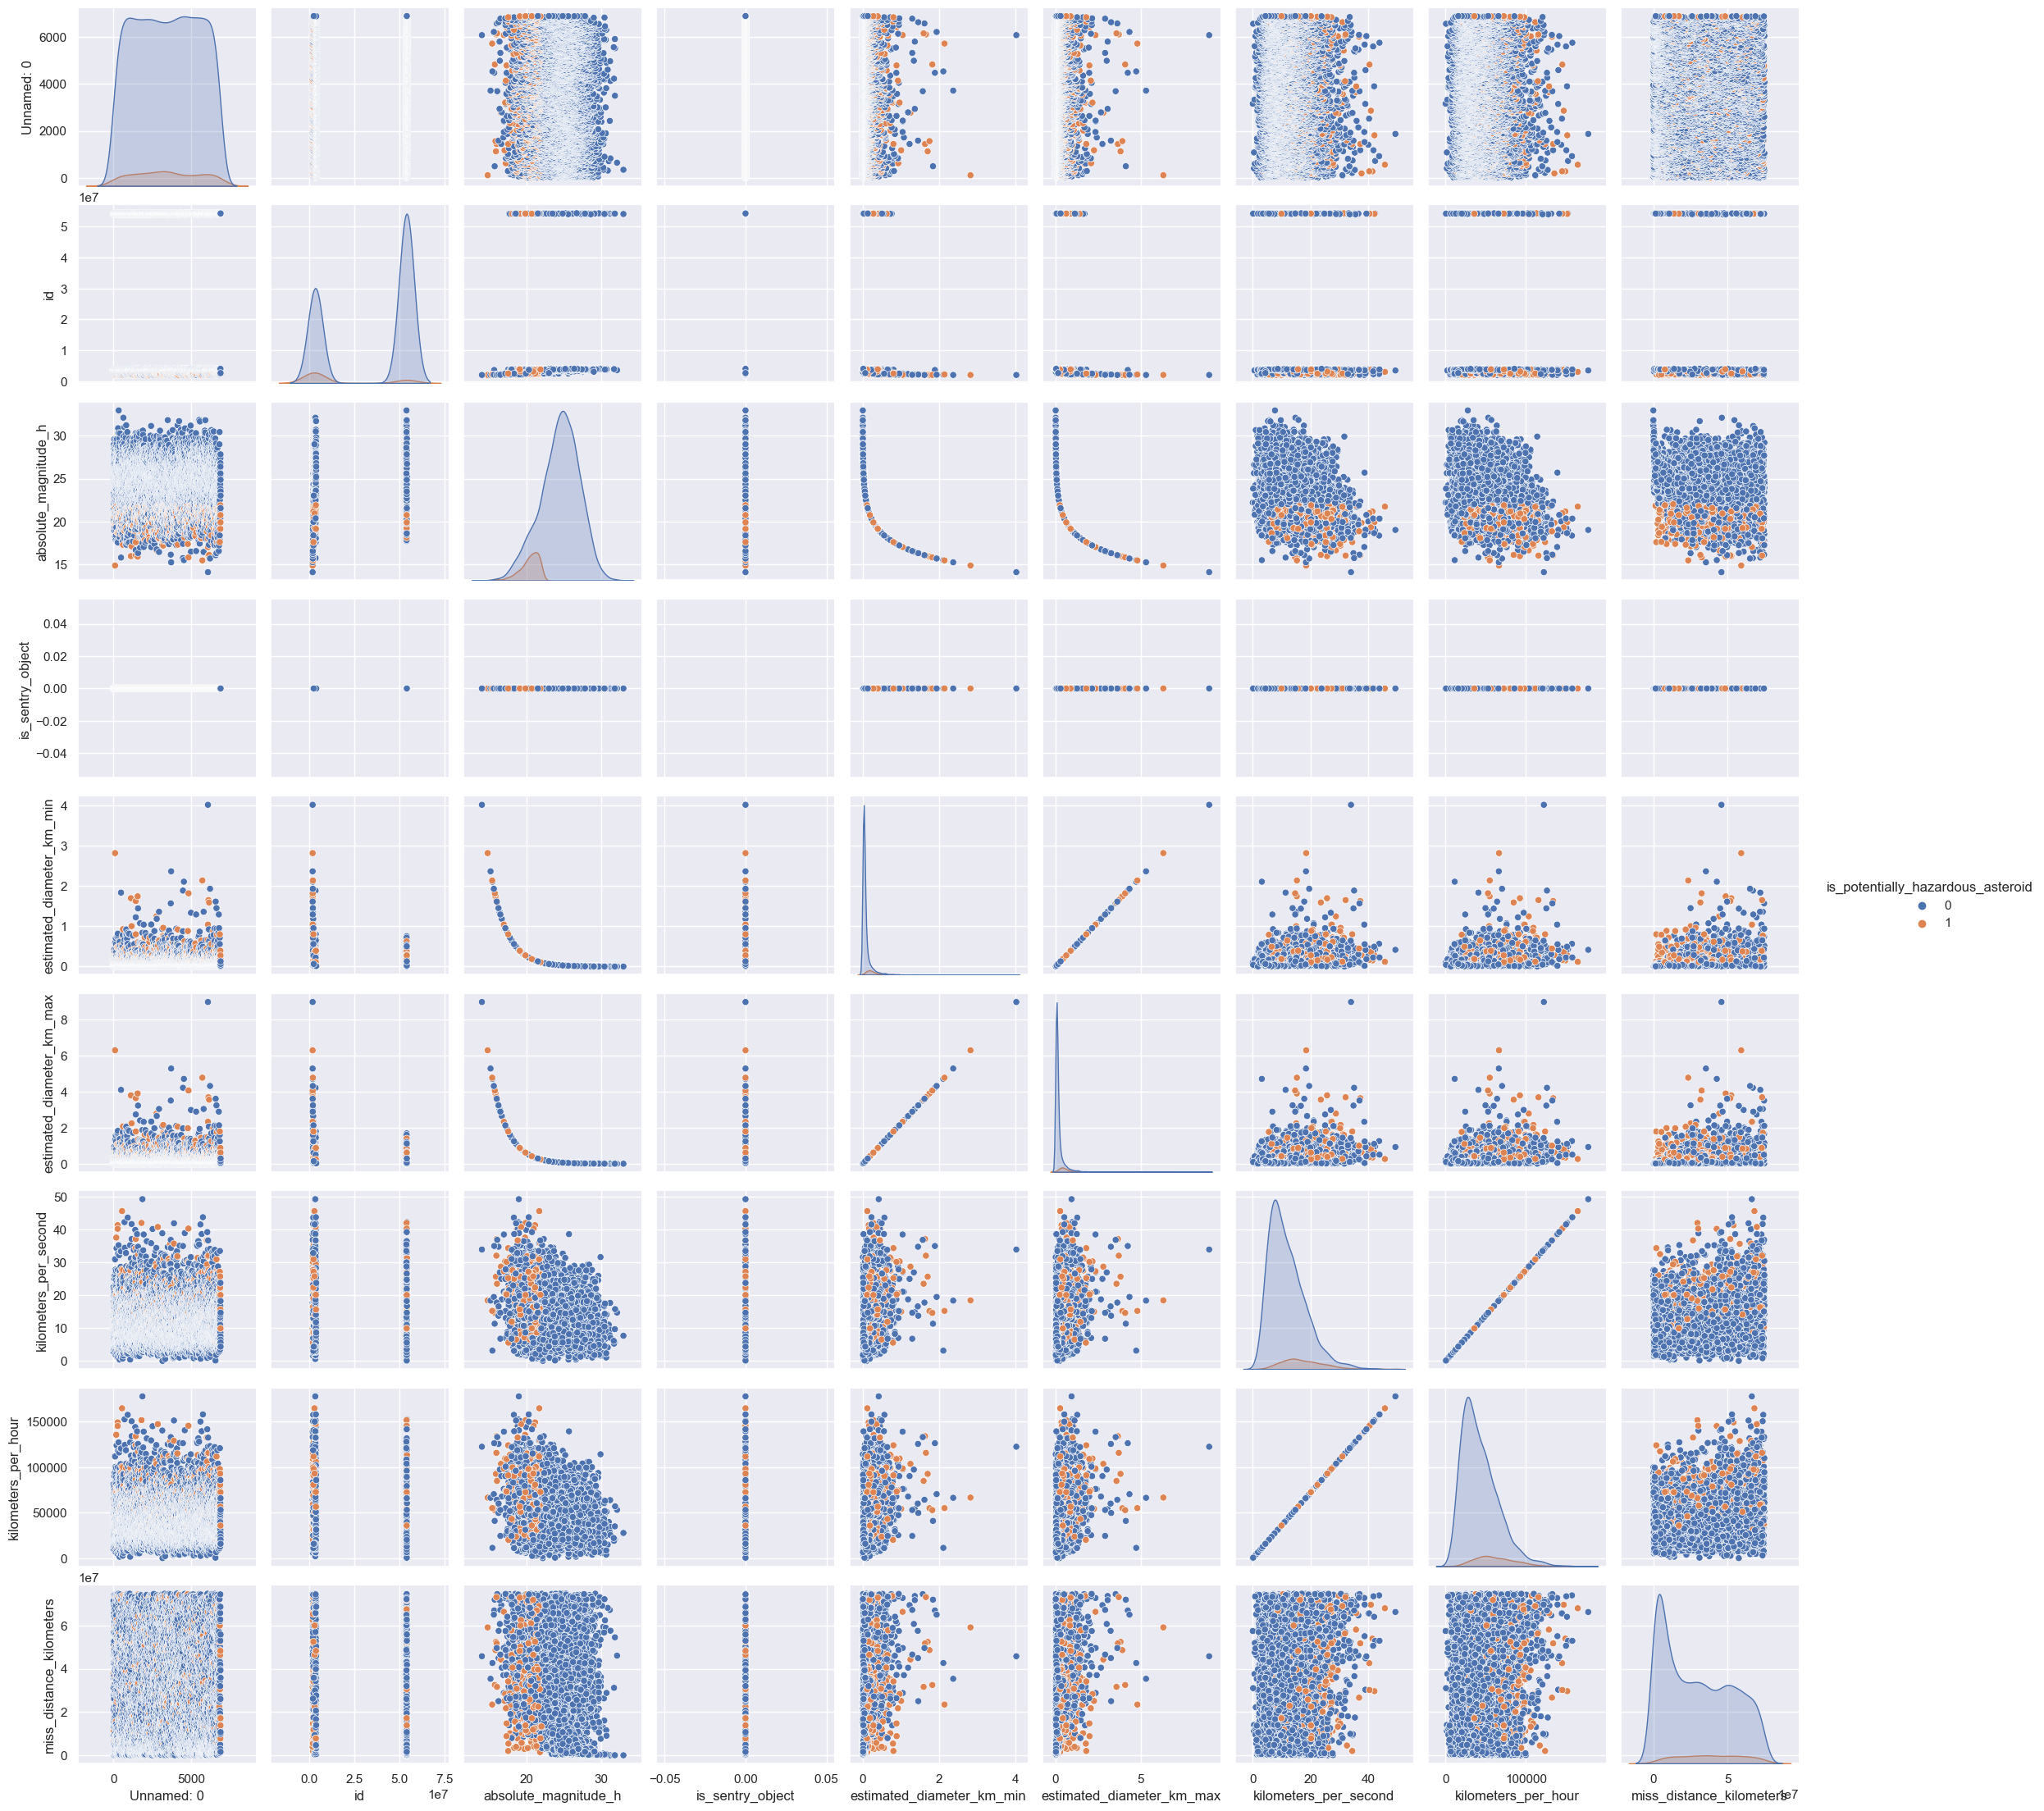

In [64]:
sns.pairplot(
    data=df0, 
    aspect=1,
    hue='is_potentially_hazardous_asteroid')